# Import dataset

In [8]:
import numpy as np
import matplotlib.pyplot as plt

image_size = 28 # width and length
no_of_different_labels = 10 #  i.e. 0, 1, 2, 3, ..., 9
image_pixels = image_size * image_size
data_path = ""
train_data = np.loadtxt(data_path + "mnist_train.csv", 
                        delimiter=",")
test_data = np.loadtxt(data_path + "mnist_test.csv", 
                       delimiter=",") 
test_data[:10]

array([[7., 0., 0., ..., 0., 0., 0.],
       [2., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [9., 0., 0., ..., 0., 0., 0.],
       [5., 0., 0., ..., 0., 0., 0.],
       [9., 0., 0., ..., 0., 0., 0.]])

In [70]:
fac = 0.99 / 255
train_imgs = np.asfarray(train_data[:, 1:]) * fac + 0.01
test_imgs = np.asfarray(test_data[:, 1:]) * fac + 0.01

train_labels = np.asfarray(train_data[:, :1])
test_labels = np.asfarray(test_data[:, :1])

In [71]:
train_imgs[0]

array([0.01      , 0.01      , 0.01      , 0.01      , 0.01      ,
       0.01      , 0.01      , 0.01      , 0.01      , 0.01      ,
       0.01      , 0.01      , 0.01      , 0.01      , 0.01      ,
       0.01      , 0.01      , 0.01      , 0.01      , 0.01      ,
       0.01      , 0.01      , 0.01      , 0.01      , 0.01      ,
       0.01      , 0.01      , 0.01      , 0.01      , 0.01      ,
       0.01      , 0.01      , 0.01      , 0.01      , 0.01      ,
       0.01      , 0.01      , 0.01      , 0.01      , 0.01      ,
       0.01      , 0.01      , 0.01      , 0.01      , 0.01      ,
       0.01      , 0.01      , 0.01      , 0.01      , 0.01      ,
       0.01      , 0.01      , 0.01      , 0.01      , 0.01      ,
       0.01      , 0.01      , 0.01      , 0.01      , 0.01      ,
       0.01      , 0.01      , 0.01      , 0.01      , 0.01      ,
       0.01      , 0.01      , 0.01      , 0.01      , 0.01      ,
       0.01      , 0.01      , 0.01      , 0.01      , 0.01   

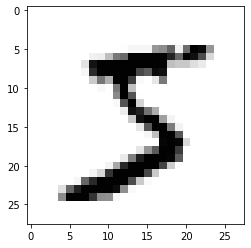

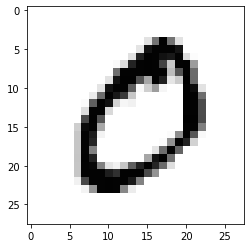

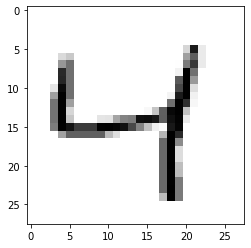

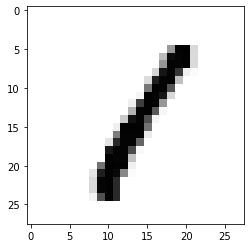

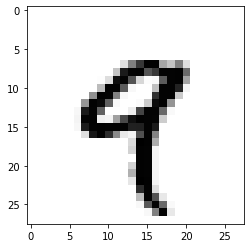

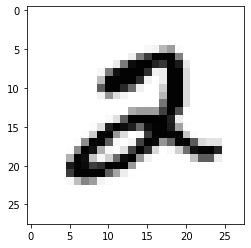

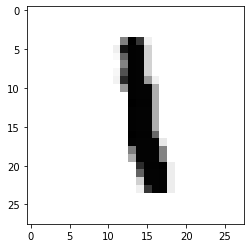

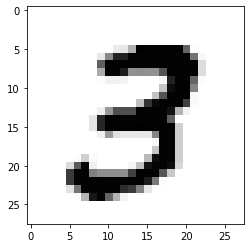

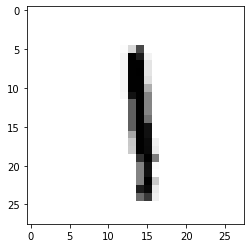

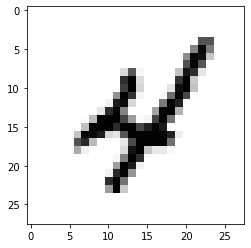

In [72]:

for i in range(10):
    img = train_imgs[i].reshape((28,28))
    plt.imshow(img, cmap="Greys")
    plt.show()

In [73]:
import cv2

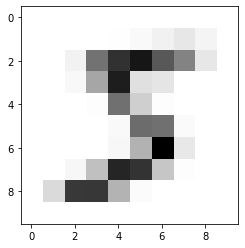

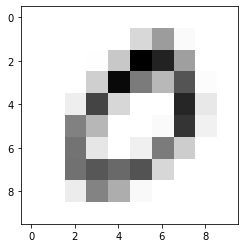

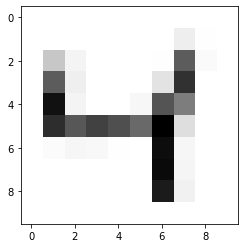

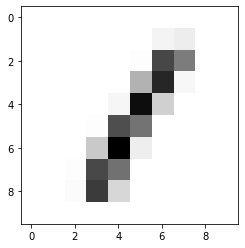

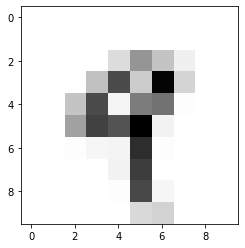

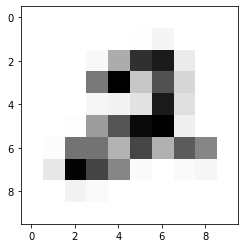

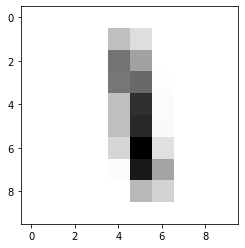

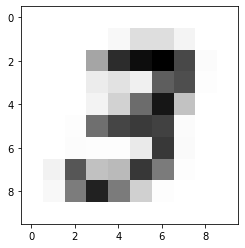

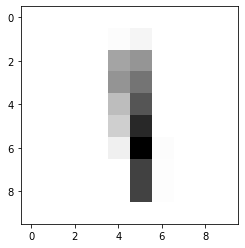

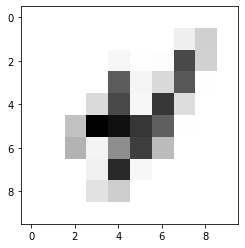

In [74]:
for i in range(10):
    resized = cv2.resize(train_imgs[i].reshape((28,28)), (10, 10), interpolation = cv2.INTER_AREA)
    plt.imshow(resized, cmap="Greys")
    plt.show()

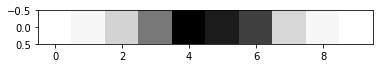

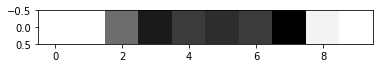

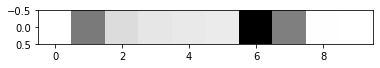

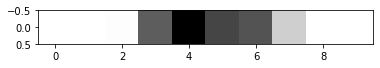

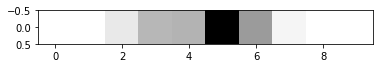

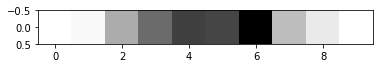

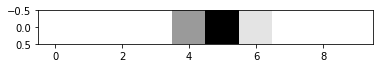

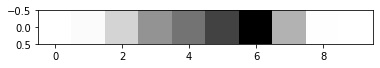

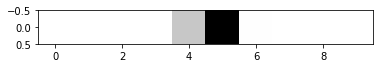

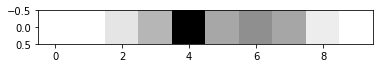

In [75]:
for i in range(10):
    resized = cv2.resize(train_imgs[i].reshape((28,28)), (10, 1), interpolation = cv2.INTER_AREA)
    plt.imshow(resized, cmap="Greys")
    plt.show()

# QNN model

In [76]:
# import libraries
from Qsun.Qcircuit import *
from Qsun.Qgates import *
from Qsun.Qmeas import *
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
import time
from sklearn.metrics import accuracy_score

# one layer with full entanglement
def layer(circuit, params):
    circuit_layer = circuit
    n_qubit = len(params)
    for i in range(n_qubit):
        RX(circuit_layer, i, params[i][0])
        RY(circuit_layer, i, params[i][1])
    for i in range(n_qubit-1):
        CNOT(circuit_layer, i, i+1)
    CNOT(circuit_layer, n_qubit-1, 0)
    return circuit_layer

# encoding the features
def initial_state(sample):
    circuit_initial = Qubit(len(sample))
    ampli_vec = np.array([np.sqrt(sample[0]), np.sqrt(1-sample[0])])
    for i in range(1, len(sample)):
        ampli_vec = np.kron(ampli_vec, np.array([np.sqrt(sample[i]), np.sqrt(1-sample[i])]))
    circuit_initial.amplitude = ampli_vec
    return circuit_initial

# QNN circuit
def qnn(circuit, params):
    n_layer = len(params)
    circuit_qnn = circuit
    for i in range(n_layer):
        circuit_qnn = layer(circuit_qnn, params[i])
    return circuit_qnn

# QNN model
def qnn_model(sample, params):
    circuit_model = initial_state(sample)
    circuit_model = qnn(circuit_model, params)
    return circuit_model

# activation function
def sigmoid(x):
    return 1 / (1 + math.exp(-10*x))

# make a prediction
def predict(circuit):
    prob_0 = measure_one(circuit, 0)
    prob_1 = measure_one(circuit, 1)
    expval_0 = prob_0[1]
    expval_1 = prob_1[1]
    pred = sigmoid(expval_0-expval_1)
    return np.array([pred, 1-pred]

# make a prediction for ex
def predict_ex(circuit):
    prob_0 = measure_one(circuit, 0)
    prob_1 = measure_one(circuit, 1)
    expval_0 = prob_0[1]
    expval_1 = prob_1[1]
    return [expval_0, expval_1]

# loss function    
def square_loss(labels, predictions):
    loss = 0
    for l, p in zip(labels, predictions):
        loss = loss + (1 - p[l]) ** 2
    loss = loss / len(labels)
    return loss

# loss function of QNN
def cost(params, features, labels):
    preds = [predict(qnn_model(x, params)) for x in features]
    return square_loss(labels, preds)

# gradient descent with QDP
def grad(X_true, y_true, params, shift, eta, drop_rate):
    diff = np.zeros(params.shape)
    for i in range(len(params)):
        for j in range(len(params[i])):
            for k in range(len(params[i][j])):
                dropout = np.random.choice([0, 1], 1, p = [1 - drop_rate, drop_rate])[0]
                if dropout == 0:
                    params_1 = params.copy()
                    params_2 = params.copy()
                    params_1[i][j][k] += shift
                    params_2[i][j][k] -= shift
                    for x, y in zip(X_true, y_true):
                        circuit = qnn_model(x, params)
                        circuit_1 = qnn_model(x, params_1)
                        circuit_2 = qnn_model(x, params_2)
                        ex_plus = predict_ex(circuit_1)
                        ex_subs = predict_ex(circuit_2)
                        pred = predict(circuit)
                        diff_loss = ((-1)**y)*(-2)*(1-pred[y])*pred[y]*(1-pred[y])
                        diff_ex = 10*((ex_plus[0] - ex_subs[0]) - (ex_plus[1] - ex_subs[1]))/(2*np.sin(shift))
                        diff[i][j][k] += diff_loss*diff_ex
                                                
    diff /= len(y_true)                
    params -= eta*diff
                
    return params

# adagrad: https://d2l.ai/chapter_optimization/adagrad.html                        

def adagrad(X_true, y_true, params, s, shift, eta, drop_rate, eps):
    diff = np.zeros(params.shape)
    for i in range(len(params)):
        for j in range(len(params[i])):
            for k in range(len(params[i][j])):
                dropout = np.random.choice([0, 1], 1, p = [1 - drop_rate, drop_rate])[0]
                if dropout == 0:
                    params_1 = params.copy()
                    params_2 = params.copy()
                    params_1[i][j][k] += shift
                    params_2[i][j][k] -= shift
                    for x, y in zip(X_true, y_true):
                        circuit = qnn_model(x, params)
                        circuit_1 = qnn_model(x, params_1)
                        circuit_2 = qnn_model(x, params_2)
                        ex_plus = predict_ex(circuit_1)
                        ex_subs = predict_ex(circuit_2)
                        pred = predict(circuit)
                        diff_loss = ((-1)**y)*(-2)*(1-pred[y])*pred[y]*(1-pred[y])
                        diff_ex = 10*((ex_plus[0] - ex_subs[0]) - (ex_plus[1] - ex_subs[1]))/(2*np.sin(shift))
                        diff[i][j][k] += diff_loss*diff_ex
                                                
    diff /= len(y_true)
    s += diff**2
    params -= eta*diff/np.sqrt(s+eps)
                
    return params, s

# https://d2l.ai/chapter_optimization/adam.html?highlight=adam

def adam(X_true, y_true, params, v, s, shift, eta, drop_rate, beta1, beta2, eps, iter_num):
    diff = np.zeros(params.shape)
    for i in range(len(params)):
        for j in range(len(params[i])):
            for k in range(len(params[i][j])):
                dropout = np.random.choice([0, 1], 1, p = [1 - drop_rate, drop_rate])[0]
                if dropout == 0:
                    params_1 = params.copy()
                    params_2 = params.copy()
                    params_1[i][j][k] += shift
                    params_2[i][j][k] -= shift
                    for x, y in zip(X_true, y_true):
                        circuit = qnn_model(x, params)
                        circuit_1 = qnn_model(x, params_1)
                        circuit_2 = qnn_model(x, params_2)
                        ex_plus = predict_ex(circuit_1)
                        ex_subs = predict_ex(circuit_2)
                        pred = predict(circuit)
                        diff_loss = ((-1)**y)*(-2)*(1-pred[y])*pred[y]*(1-pred[y])
                        diff_ex = 10*((ex_plus[0] - ex_subs[0]) - (ex_plus[1] - ex_subs[1]))/(2*np.sin(shift))
                        diff[i][j][k] += diff_loss*diff_ex
                                                
    diff /= len(y_true)
    v = beta1 * v + (1 - beta1) * diff
    s = beta2 * s + (1 - beta2) * (diff**2)
    v_bias_corr = v / (1 - beta1 ** (iter_num+1))
    s_bias_corr = s / (1 - beta2 ** (iter_num+1))
    params -= eta * v_bias_corr / (np.sqrt(s_bias_corr) + eps)
    
    return params, v, s

In [77]:
def qnn_training(X_true, y_true, params, max_ieration, shift=np.pi/20, eta=0.1, drop_rate=0.1, choice='grad'):
    if choice == 'grad':
        for k in range(max_ieration):
            params = grad(X_train, y_train, params, shift, eta, drop_rate)
    elif choice == 'adagrad':
        s = np.zeros(params.shape)
        for k in range(max_ieration):
            params, s = adagrad(X_train, y_train, params, s, shift, eta, drop_rate, 1e-6)
    elif choice == 'adam':
        v = np.zeros(params.shape)
        s = np.zeros(params.shape)
        for k in range(max_ieration):
            params, v, s = adam(X_train, y_train, params, v, s, shift, eta, drop_rate, 0.9, 0.999, 1e-6, k)
    return params

In [78]:
X_train = []
y_train = train_labels
X_test = []
y_test = test_labels

for i in range(len(train_imgs)):
    X_train.append(cv2.resize(train_imgs[i].reshape((28,28)), (10, 1), interpolation = cv2.INTER_AREA)[0])
    
for i in range(len(test_imgs)):
    X_test.append(cv2.resize(test_imgs[i].reshape((28,28)), (10, 1), interpolation = cv2.INTER_AREA)[0])

X_train = np.array(X_train)
X_test = np.array(X_test)

In [79]:
X_train

array([[0.01      , 0.03208584, 0.10510775, ..., 0.09741237, 0.0337497 ,
        0.01      ],
       [0.01      , 0.01      , 0.20465248, ..., 0.3106843 , 0.03855312,
        0.01      ],
       [0.01      , 0.20833675, 0.0869736 , ..., 0.20157234, 0.013506  ,
        0.01      ],
       ...,
       [0.01      , 0.01989406, 0.06878002, ..., 0.07969418, 0.05471639,
        0.01      ],
       [0.01      , 0.01      , 0.11084215, ..., 0.16985986, 0.03917707,
        0.01      ],
       [0.01      , 0.01      , 0.10884154, ..., 0.1339679 , 0.07329622,
        0.0197455 ]])

In [80]:
cv2.resize(train_imgs[0].reshape((28,28)), (10, 1), interpolation = cv2.INTER_AREA)[0]

array([0.01      , 0.03208584, 0.10510775, 0.21728003, 0.35349913,
       0.31995441, 0.2839436 , 0.09741237, 0.0337497 , 0.01      ])

In [83]:
n_layer = 1
params = np.zeros((n_layer, len(X_train[0]), len(X_train[0]),)) 
qnn_model(X_train[0], params).visual_circuit()

|Q_0> : RX-RY-------------------------------------------------------o--------------------------x---M
                                                                    |                          |    
|Q_1> : ------RX-RY-------------------------------------------------x--o---------------------------M
                                                                       |                       |    
|Q_2> : ------------RX-RY----------------------------------------------x--o------------------------M
                                                                          |                    |    
|Q_3> : ------------------RX-RY-------------------------------------------x--o---------------------M
                                                                             |                 |    
|Q_4> : ------------------------RX-RY----------------------------------------x--o------------------M
                                                                                |          